In [ ]:
#default_exp data.block

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.core import *
from local.data.load import *
from local.data.external import *
from local.data.transforms import *

In [ ]:
from local.notebook.showdoc import show_doc

# Data block

> High level API to quickly get your data in a `DataBunch`

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    return L(v[-1] for k,v in g.items()).map(instantiate)

In [ ]:
#For example, so not exported
from local.vision.core import *
from local.vision.augment import *

In [ ]:
#hide
tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    get_x=get_items=splitter=get_y = None
    _methods = 'get_items splitter get_y get_x'.split()
    def __init__(self, types=None, **kwargs):
        types = L(getattr(self,'types',(float,float)) if types is None else types)
        self.default_type_tfms = types.map(
            lambda t: L(getattr(t,'create',None)) + L(getattr(t,'default_type_tfms',None)))
        self.default_item_tfms  = _merge_tfms(ToTensor, *types.attrgot('default_item_tfms',  L()))
        self.default_batch_tfms = _merge_tfms(Cuda,     *types.attrgot('default_batch_tfms', L()))
        assert not kwargs

    def datasource(self, source, type_tfms=None):
        self.source = source
        items = (self.get_items or noop)(source)
        if isinstance(items,tuple):
            items = L(items).zip()
            labellers = [itemgetter(i) for i in range_of(self.default_type_tfms)]
        else: labellers = [noop] * len(self.default_type_tfms)
        splits = (self.splitter or noop)(items)
        if self.get_x: labellers[0] = self.get_x
        if self.get_y: labellers[1] = self.get_y
#         if self.get_x: labellers[0] = compose(self.get_x)
#         if self.get_y: labellers[1] = compose(self.get_y)
        if type_tfms is None: type_tfms = [L() for t in self.default_type_tfms]
        type_tfms = L([self.default_type_tfms, type_tfms, labellers]).map_zip(
            lambda tt,tfm,l: L(l) + _merge_tfms(tt, tfm))
        return DataSource(items, tfms=type_tfms, splits=splits)

    def databunch(self, source, type_tfms=None, item_tfms=None, batch_tfms=None, bs=16, **kwargs):
        dsrc = self.datasource(source, type_tfms=type_tfms)
        item_tfms = _merge_tfms(self.default_item_tfms, item_tfms)
        batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return dsrc.databunch(bs=bs, after_item=item_tfms, after_batch=batch_tfms, **kwargs)

    _docs = dict(datasource="Create a `Datasource` from `source` with `tfms` and `tuple_tfms`",
                 databunch="Create a `DataBunch` from `source` with `tfms`")

To build a `DataBlock` you need to give the library four things: the types of your input/labels then at least two functions: `__getitem__` and `splitter`. You may also need to include `get_x` and `get_y`.

Once those are provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="DataBlock.datasource" class="doc_header"><code>DataBlock.datasource</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`type_tfms`**=*`None`*)

Create a `Datasource` from `source` with `tfms` and `tuple_tfms`

In [ ]:
show_doc(DataBlock.databunch)

<h4 id="DataBlock.databunch" class="doc_header"><code>DataBlock.databunch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`type_tfms`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`16`*, **\*\*`kwargs`**)

Create a [`DataBunch`](/data.core.html#DataBunch) from `source` with `tfms`

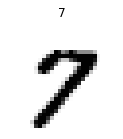

In [ ]:
class MNIST(DataBlock):
    types = PILImageBW,Category
    def get_items(self, source): return get_image_files(Path(source))
    def splitter (self, items ): return GrandparentSplitter()(items)
    def get_y    (self, item  ): return parent_label(item)

mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
test_eq(mnist.vocab, ['3', '7'])
x,y = mnist.train[0]
test_eq(x.size,(28,28))
show_at(mnist.train, 0, cmap='Greys', figsize=(2,2));

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_transform.ipynb.
Converted 02_script.ipynb.
Converted 03_torch_core.ipynb.
Converted 04_dataloader.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_vision_learner.ipynb.
Converted 22_tutorial_imagenette.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Conver